In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.corpus import words
from textblob import TextBlob
nltk.download('punkt')
plot_df = pd.read_pickle("final_plot.pkl")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sibongiletoure/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Cleaning the plots_df
* After merging the plots some have NaNs.I will drop those
* Some plots also have multiple plots attached to it.I will take the longest one and drop the writer by splitting it at the '::'
* Finally I will add the year of release for topic modeling later

In [2]:
plot_df = plot_df.dropna().reset_index(drop=True)

In [3]:
plots_list = []
for movie_plots in plot_df['plot']:
    max_plot_len = 0
    max_plot = ''
    for plot in movie_plots:
        if max_plot_len <= len(plot):
            max_plot = plot
            max_plot_len = len(plot)
        max_plot = max_plot.split('::')[0]
    plots_list.append(max_plot)    
#plots_list
plot_df['plot'] = plots_list

In [4]:
import re
year_list = []
for date in plot_df['release_date']:
    year = re.findall("\d{4}", date)[0]
    year_list.append(int(year))
plot_df['year_of_release'] = year_list

In [94]:
plot_df

,title,title_id,genres,release_date,plot,year_of_release
0,Summer Stock,tt0043012,"Musical, Romance",31 August 1950,"As a favor to her actress sister Abigail, New ...",1950
1,In a Lonely Place,tt0042593,"Drama, Film-Noir, Mystery",17 May 1950,Dixon Steele is a Hollywood screenwriter who h...,1950
2,Sunset Blvd.,tt0043014,"Drama, Film-Noir",10 August 1950,Joe Gillis is a struggling hack B-movie Hollyw...,1950
3,Cinderella,tt0042332,"Animation, Family, Fantasy",15 February 1950,"In a far away, long ago kingdom, Cinderella is...",1950
4,All About Eve,tt0042192,Drama,13 October 1950,Stage star Margo Channing is friend to playwri...,1950
...,...,...,...,...,...,...
53602,Sang froid,tt11895902,Drama,11 September 2020,"Claire is a lawyer. Obsessed with her work, sh...",2020
53603,Bitterzoet Concert Film,tt12626546,Music,3 July 2020,"In January 2020, Eefje released her fourth alb...",2020
53604,Kiwewe Nyeusi (Black Trauma),tt12798962,Drama,6 July 2020,Kiwewe Nyeusi is Swahili for the words Black T...,2020
53605,Who Laughs in Hell,tt12007548,"Comedy, Drama, Thriller",25 March 2020,"King (Liam Bilsky) is an extremely hostile, mo...",2020


### Topic Modeling

In [5]:
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['want','ha','ca','ago','know','may','would','go'\
               ,'wa','also','old','year','two','one',\
               'film', 'movie', 'feature', 'director', 'short', 'filmmaker', 'character', 'star', 'comedy', 'based',\
                'story', 'based', 'tells', 'true', 'directed','find','way','must','meet',\
               'de', 'la', 'un', 'su', 'en', 'el', 'que', 'una', 'se', 'le','three',
               'time', 'day', 'take', 'people', 'make', 'first', 'come', 'work', 'place', 'night',\
               'yearold','dy','little','named','back','doe','tell','get','hi','thi','becomes']
stopwords.extend(newStopWords)
stop_words = set(stopwords) 

In [6]:

# res = corpus[84].replace(key, cities[key])
# cities =  {"New York":"New_York",
#             'Los Angeles':'Los_Angeles',
#             'Hong Kong':'Hong_Kong',
#             'San Fransisco':'San_Fransisco',
#             'New Dehli':'New_Dehli'}
# for city, city_val in cities.items():
#     res = corpus[84].replace(city,city_val)
    
# for key in cities.keys():
#     if key in corpus[84]:
#         res = corpus[84].replace(key, cities[key])
# res

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
import pickle
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import TreebankWordTokenizer
from autocorrect import Speller

class NLPPipe:
   
    def __init__(self, vectorizer=CountVectorizer(), tokenizer=None, cleaning_function=None, 
                 lemmatizer=None,model=None):
        if not tokenizer:
            tokenizer = self.splitter
        if not cleaning_function:
            cleaning_function = self.clean_text
        self.lemmatizer = lemmatizer
        self.tokenizer = tokenizer
        self.model = model
        self.cleaning_function = cleaning_function
        self.vectorizer = vectorizer
        self._is_fit = False
        
    def splitter(self, text):
        return text.split(' ')
        
    
    def fit_transform(self, text):
        clean_text = self.cleaning_function(text, self.tokenizer, self.lemmatizer)
        return self.vectorizer.fit_transform(clean_text)

In [8]:
corpus = plot_df['plot']

In [9]:
def clean_text(text, tokenizer, lemmatizer):
    ''' 
    Clean the text with tokenization and lemmatization
    Map popular two name cities into one name with an underscore
    '''
    cities =  {"New York":"New_York",
    'Los Angeles':'Los_Angeles',
    'Hong Kong':'Hong_Kong',
    'San Fransisco':'San_Fransisco',
    'New Delhi':'New_Delhi',
    'Sao Paulo':'Sao_Paulo',
     'Mexico City':'Mexico_City'}
    text=text.str.replace(r'\d+','')
    text=text.replace(r'[^A-Za-z0-9 ]+', '', regex=True)
    cleaned_text = []
    for post in text:
        for key in cities.keys():
            if key in post:
                post = post.replace(key, cities[key])
        post = post.replace('World War II','WWII')
        cleaned_words = []
        for word in tokenizer(post):
            low_word = word.lower()
            if lemmatizer:
                low_word = lemmatizer.lemmatize(low_word)
            cleaned_words.append(low_word)
        cleaned_text.append(' '.join(cleaned_words))
    return cleaned_text

### NMF with count vectorizer

In [10]:
nlp = NLPPipe(vectorizer=CountVectorizer(stop_words = stop_words,max_df=0.7,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

count_result = nlp.fit_transform(corpus)

In [11]:
from sklearn.decomposition import NMF
nmf_model = NMF(10)
doc_topic = nmf_model.fit_transform(count_result)

In [12]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [13]:
display_topics(nmf_model, nlp.vectorizer.get_feature_names(), 10)


Topic  0
new, wife, world, police, money, war, help, town, end, however

Topic  1
life, change, world, new, relationship, living, live, dream, like, past

Topic  2
love, fall, fall love, girl, marriage, married, relationship, marry, beautiful, daughter

Topic  3
family, daughter, brother, home, child, wife, son, house, parent, sister

Topic  4
young, woman, young woman, young man, husband, girl, men, village, beautiful, relationship

Topic  5
kkk, court, nahata, case, print, prosecution, gandhi, supreme, supreme court, sanjay

Topic  6
father, mother, son, daughter, child, home, brother, sister, house, death

Topic  7
school, girl, boy, student, high, high school, teacher, parent, class, new

Topic  8
man, young man, young, wife, another, kill, see, rich, men, black

Topic  9
friend, best, best friend, help, friendship, together, childhood, girlfriend, become, party


### Topics are interesting but I feel they could tell me more 
* Trying NMF with a min_df of 1% and 15 words for each topic

In [14]:
nlp = NLPPipe(vectorizer=CountVectorizer(stop_words = stop_words,min_df=0.01,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

count_result = nlp.fit_transform(corpus)

In [15]:
count_result.shape

(53607, 641)

In [16]:
from sklearn.decomposition import NMF
nmf_model = NMF(10)
doc_topic = nmf_model.fit_transform(count_result)

In [17]:
display_topics(nmf_model, nlp.vectorizer.get_feature_names(), 15)


Topic  0
new, world, police, wife, town, money, help, however, end, war, try, house, home, job, even

Topic  1
life, change, relationship, world, living, new, live, dream, like, past, different, job, lead, end, around

Topic  2
love, fall, fall love, girl, marriage, relationship, married, marry, beautiful, daughter, end, heart, together, lover, affair

Topic  3
family, daughter, brother, home, son, wife, child, house, sister, parent, married, member, marriage, husband, return

Topic  4
friend, school, best, best friend, girl, high, student, high school, boy, friendship, help, together, college, childhood, become

Topic  5
father, son, daughter, village, death, boy, brother, return, home, wife, house, sister, marry, away, relationship

Topic  6
young, girl, boy, young man, young woman, young girl, village, world, dream, city, set, town, couple, beautiful, small

Topic  7
man, young man, wife, another, kill, see, men, dead, black, daughter, killed, rich, murder, past, job

Topic  8
woma

## TFIDF
* The topics are pretty good but very similar want to see if using TFIDF gives any clarity
* Also switched from a min_df of 1% to a max_df of 50%

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

class NLPPipe:
   
    def __init__(self, vectorizer= TfidfVectorizer(), tokenizer=None, cleaning_function=None, 
                 lemmatizer=None,model=None):
        if not tokenizer:
            tokenizer = self.splitter
        if not cleaning_function:
            cleaning_function = self.clean_text
        self.lemmatizer = lemmatizer
        self.tokenizer = tokenizer
        self.model = model
        self.cleaning_function = cleaning_function
        self.vectorizer = vectorizer
        self._is_fit = False
        
    def splitter(self, text):
        return text.split(' ')
        
 
    
    def fit_transform(self, text):
        clean_text = self.cleaning_function(text, self.tokenizer, self.lemmatizer)
        return self.vectorizer.fit_transform(clean_text)

In [19]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stop_words,max_df=0.5,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

tf_result = nlp.fit_transform(corpus)

In [20]:
nmf_model = NMF(10)
doc_topic = nmf_model.fit_transform(tf_result)

In [21]:
display_topics(nmf_model, nlp.vectorizer.get_feature_names(), 15)


Topic  0
friend, new, police, money, town, wife, try, help, job, start, house, murder, best, thing, plan

Topic  1
man, young, wife, past, another, mysterious, rich, revenge, dream, memory, struggle, journey, prison, decides, killed

Topic  2
father, mother, son, child, daughter, brother, death, sister, home, return, wife, boy, care, husband, away

Topic  3
love, fall, relationship, marriage, married, couple, romantic, beautiful, marry, lover, heart, daughter, affair, triangle, end

Topic  4
life, change, different, world, new, dream, forever, living, live, struggle, journey, event, around, reality, past

Topic  5
girl, boy, young, teenage, parent, dream, guy, rich, summer, fall, village, friend, poor, adventure, friendship

Topic  6
woman, young, husband, men, relationship, married, beautiful, lover, child, different, affair, marriage, try, boyfriend, mysterious

Topic  7
war, world, village, soldier, german, army, group, set, fight, small, wwii, country, battle, men, japanese

Topic

### Tfidf vectorizer NMF with min_df of 0.01 and ngram_range of 2

In [25]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stop_words,min_df=0.01,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

tf_result = nlp.fit_transform(corpus)

In [26]:
tf_result.shape

(53607, 5765)

In [27]:
nmf_model = NMF(10)
doc_topic = nmf_model.fit_transform(tf_result)

In [28]:
display_topics(nmf_model, nlp.vectorizer.get_feature_names(), 10)


Topic  0
world, war, police, town, new, set, group, small, city, murder

Topic  1
love, fall, fall love, marriage, married, marry, relationship, beautiful, romantic, lover

Topic  2
man, young, young man, wife, man life, past, rich, dream, another man, mysterious

Topic  3
father, mother, son, child, daughter, home, wife, brother, sister, house

Topic  4
life, change, new, dream, different, change life, relationship, world, living, live

Topic  5
girl, boy, young, young girl, village, young boy, teenage, parent, dream, boy girl

Topic  6
woman, young woman, young, husband, men, relationship, married, beautiful, lover, beautiful woman

Topic  7
friend, best, best friend, friendship, childhood, together, childhood friend, four, help, girlfriend

Topic  8
family, brother, member, home, struggle, family member, house, parent, daughter, family life

Topic  9
school, student, high, high school, teacher, school student, class, college, school teacher, new


## NMF with min .01 and max 0.5

In [29]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stop_words,min_df=0.001,max_df=0.5,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

tf_result = nlp.fit_transform(corpus)

In [30]:
nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(tf_result)

In [31]:
display_topics(nmf_model, nlp.vectorizer.get_feature_names(), 10)


Topic  0
friend, school, world, new, town, war, group, police, help, set

Topic  1
love, fall, fall love, girl, marriage, married, marry, relationship, beautiful, friend

Topic  2
young, man, woman, young man, young woman, husband, young girl, men, girl, wife

Topic  3
family, father, mother, son, daughter, child, brother, home, wife, sister

Topic  4
life, change, new, different, relationship, change life, dream, world, living, live


## NMF with stemming instead of lemmitization

In [32]:
newStemmedStopWords = ['want','ha','ca','ago','know','may','would','go'\
               ,'wa','also','old','year','two','one',\
               'film', 'movie', 'feature', 'director', 'short', 'filmmaker', 'character', 'star', 'comedy', 'based',\
                'story', 'based', 'tells', 'true', 'directed','find','way','must','meet',\
               'de', 'la', 'un', 'su', 'en', 'el', 'que', 'una', 'se', 'le','three',
               'time', 'day', 'take', 'people', 'make', 'first', 'come', 'work', 'place', 'night',\
               'yearold','dy','little','named','back','doe','tell','get','hi','thi','stori', 'movi', 'base','charact',\
                'set','onli','dure','name','four','tri','th']
stopwords.extend(newStemmedStopWords)
stemmed_stop_words = set(stopwords) 

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
import pickle
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import TreebankWordTokenizer
from autocorrect import Speller
from nltk.stem import PorterStemmer

class NLPPipe:
   
    def __init__(self, vectorizer=CountVectorizer(), tokenizer=None, cleaning_function=None, 
                 stemmer=None,model=None):
        if not tokenizer:
            tokenizer = self.splitter
        if not cleaning_function:
            cleaning_function = self.clean_text
        self.stemmer = stemmer
        self.tokenizer = tokenizer
        self.model = model
        self.cleaning_function = cleaning_function
        self.vectorizer = vectorizer
        self._is_fit = False
        
    def splitter(self, text):
        return text.split(' ')
        
 
    
    def fit_transform(self, text):
        clean_text = self.cleaning_function(text, self.tokenizer, self.stemmer)
        return self.vectorizer.fit_transform(clean_text)

In [34]:
def clean_text(text, tokenizer, stemmer):
        cities =  {"New York":"New_York",
        'Los Angeles':'Los_Angeles',
        'Hong Kong':'Hong_Kong',
        'San Fransisco':'San_Fransisco',
        'New Delhi':'New_Delhi',
        'Sao Paulo':'Sao_Paulo',
         'Mexico City':'Mexico_City'}
        text=text.str.replace(r'\d+','')
        text=text.replace(r'[^A-Za-z0-9 ]+', '', regex=True)
        cleaned_text = []
        for post in text:
            for key in cities.keys():
                if key in post:
                    post = post.replace(key, cities[key])
            post = post.replace('World War II','WWII')
            cleaned_words = []
            for word in tokenizer(post):
                low_word = word.lower()
                if stemmer:
                    low_word = stemmer.stem(low_word)
                    #low_word = speller(low_word)
                cleaned_words.append(low_word)
            cleaned_text.append(' '.join(cleaned_words))
        return cleaned_text

In [35]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stemmed_stop_words,min_df=0.001,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              stemmer = PorterStemmer())

tf_result = nlp.fit_transform(corpus)

In [36]:
nmf_model = NMF(10)
doc_topic = nmf_model.fit_transform(tf_result)

In [37]:
display_topics(nmf_model, nlp.vectorizer.get_feature_names(), 10)


Topic  0
murder, polic, kill, war, prison, world, forc, group, investig, offic

Topic  1
love, fall, fall love, marri, marriag, beauti, relationship, lover, romant, coupl

Topic  2
father, mother, son, daughter, marri, wife, home, live, brother, husband

Topic  3
man, young, woman, young man, young woman, becom, past, mysteri, husband, wife

Topic  4
life, live, chang, world, new, dream, struggl, differ, peopl, relationship

Topic  5
girl, boy, young girl, young, littl, young boy, teenag, littl girl, parent, dream

Topic  6
villag, small, town, small villag, local, citi, live, return, mountain, peopl

Topic  7
famili, brother, member, struggl, home, famili member, children, famili live, parent, face

Topic  8
friend, best, best friend, friendship, childhood, togeth, decid, childhood friend, help, trip

Topic  9
school, student, high, high school, teacher, school student, class, graduat, colleg, school teacher


## LDA
* NMF gave pretty good topics but want to see if LDA with stemming instead of lemmitization brought any new insights to the topics

In [44]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stemmed_stop_words,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              stemmer = PorterStemmer())

tf_result = nlp.fit_transform(corpus)

In [45]:
from sklearn.decomposition import LatentDirichletAllocation
lda_tf = LatentDirichletAllocation(n_components=10, random_state=0)
lda_tf.fit(tf_result)
display_topics(lda_tf, nlp.vectorizer.get_feature_names(), 10)


Topic  0
life, love, young, man, famili, live, friend, father, girl, becom

Topic  1
life, young, love, man, live, famili, friend, father, woman, girl

Topic  2
life, love, young, man, live, friend, famili, father, girl, becom

Topic  3
life, young, love, live, famili, man, friend, girl, father, becom

Topic  4
life, love, young, live, man, famili, friend, girl, woman, father

Topic  5
life, love, live, famili, young, man, friend, girl, father, becom

Topic  6
life, love, live, young, man, famili, friend, father, becom, woman

Topic  7
life, love, famili, young, live, man, friend, father, woman, becom

Topic  8
life, love, live, famili, man, young, friend, father, girl, mother

Topic  9
life, love, live, man, young, friend, famili, father, woman, mother


### All of the topics are the same lets add a max_df

In [46]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stemmed_stop_words,max_df=0.5,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              stemmer = PorterStemmer())

tf_result = nlp.fit_transform(corpus)

In [47]:
lda_tf = LatentDirichletAllocation(n_components=10, random_state=0)
lda_tf.fit(tf_result)
display_topics(lda_tf, nlp.vectorizer.get_feature_names(), 10)


Topic  0
life, love, young, man, famili, live, friend, father, girl, becom

Topic  1
life, young, love, man, live, famili, friend, father, woman, girl

Topic  2
life, love, young, man, live, friend, famili, father, girl, becom

Topic  3
life, young, love, live, famili, man, friend, girl, father, becom

Topic  4
life, love, young, live, man, famili, friend, girl, woman, father

Topic  5
life, love, live, famili, young, man, friend, girl, father, becom

Topic  6
life, love, live, young, man, famili, friend, father, becom, woman

Topic  7
life, love, famili, young, live, man, friend, father, woman, becom

Topic  8
life, love, live, famili, man, young, friend, father, girl, mother

Topic  9
life, love, live, man, young, friend, famili, father, woman, mother


#### Still more of the same. Will add a min df

In [48]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stemmed_stop_words,min_df=0.01,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              stemmer = PorterStemmer())

tf_result = nlp.fit_transform(corpus)

In [49]:
lda_tf = LatentDirichletAllocation(n_components=10, random_state=0)
doc_topic=lda_tf.fit(tf_result)
display_topics(lda_tf, nlp.vectorizer.get_feature_names(), 10)


Topic  0
mother, father, son, child, famili, live, children, wife, life, daughter

Topic  1
life, world, love, live, past, man, dream, young, chang, journey

Topic  2
love, fall, marri, fall love, girl, young, man, famili, daughter, marriag

Topic  3
brother, famili, young, woman, father, villag, man, fight, sister, love

Topic  4
murder, polic, kill, investig, gang, crime, prison, killer, case, crimin

Topic  5
friend, town, small, best, boy, best friend, summer, life, love, friendship

Topic  6
school, music, student, play, high, high school, life, actor, perform, band

Topic  7
war, armi, soldier, german, world, group, king, american, militari, battl

Topic  8
life, live, famili, differ, peopl, social, love, relationship, like, friend

Topic  9
comedi, friend, life, love, man, guy, car, live, hotel, parti


## Start some initial plotting based on lda topics

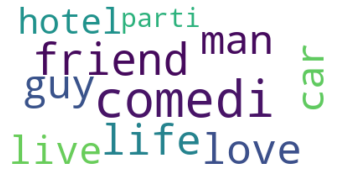

In [92]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
terms_count = 10
terms = nlp.vectorizer.get_feature_names()
#Looping over lda components to get topics and their related terms with high probabilities
for idx,topic in enumerate(lda_tf.components_):    
    #print('Topic# ',idx+1)
    abs_topic = abs(topic)
    topic_terms = [[terms[i],topic[i]] for i in abs_topic.argsort()[:-terms_count-1:-1]]
    topic_terms_sorted = [[terms[i], topic[i]] for i in abs_topic.argsort()[:-terms_count - 1:-1]]
    topic_words = []
#     for i in range(terms_count):
#         topic_words.append(topic_terms_sorted[i][0])
    #print(','.join( word for word in topic_words))
    print("")
    dict_word_frequency = {}
    for i in range(terms_count):
        dict_word_frequency[topic_terms_sorted[i][0]] = topic_terms_sorted[i][1]    
        wcloud = WordCloud(background_color="white",mask=None, max_words=100,\
                            max_font_size=60,min_font_size=10,prefer_horizontal=0.9,
                            contour_width=3,contour_color='black')
        wcloud.generate_from_frequencies(dict_word_frequency)       
        plt.imshow(wcloud, interpolation='bilinear')
        plt.axis("off")
        plt.savefig("Topic#"+str(idx+1)+".png")

In [60]:
ex_label = [c[:30]+"..." for c in corpus]

In [61]:
topic_values = lda_tf.transform(tf_result)
topic_values

array([[0.01913614, 0.01913487, 0.2704932 , ..., 0.01913744, 0.01913801,
        0.01913673],
       [0.01193217, 0.01193397, 0.01193235, ..., 0.01193454, 0.6570872 ,
        0.01193359],
       [0.01387621, 0.01387752, 0.01387672, ..., 0.01387563, 0.87511061,
        0.01387721],
       ...,
       [0.03044918, 0.03044668, 0.03044346, ..., 0.03045086, 0.72596932,
        0.03045265],
       [0.02416463, 0.02415917, 0.02415336, ..., 0.78256129, 0.02416068,
        0.02415526],
       [0.01679863, 0.01679891, 0.84880897, ..., 0.01679758, 0.01679923,
        0.0167997 ]])

In [62]:
H = pd.DataFrame(topic_values.round(5),
             index = plot_df.title,
             columns = ["topic_1","topic_2","topic_3",'topic_4','topic_5',\
                       'topic_6','topic_7','topic_8','topic_9','topic_10'])
H

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
title,,,,,,,,,,
Summer Stock,0.01914,0.01913,0.27049,0.01914,0.01914,0.01914,0.57641,0.01914,0.01914,0.01914
In a Lonely Place,0.01193,0.01193,0.01193,0.01193,0.24744,0.01193,0.01193,0.01193,0.65709,0.01193
Sunset Blvd.,0.01388,0.01388,0.01388,0.01387,0.01388,0.01388,0.01388,0.01388,0.87511,0.01388
Cinderella,0.55141,0.01468,0.01468,0.01469,0.01468,0.01468,0.01468,0.33112,0.01468,0.01468
All About Eve,0.01723,0.01723,0.44256,0.01723,0.01723,0.01723,0.41959,0.01723,0.01723,0.01723
...,...,...,...,...,...,...,...,...,...,...
Sang froid,0.75120,0.02764,0.02765,0.02764,0.02766,0.02764,0.02764,0.02764,0.02764,0.02765
Bitterzoet Concert Film,0.01553,0.01553,0.01553,0.01553,0.01553,0.01553,0.86022,0.01553,0.01553,0.01553
Kiwewe Nyeusi (Black Trauma),0.03045,0.03045,0.03044,0.03045,0.03045,0.03044,0.03045,0.03045,0.72597,0.03045


In [63]:
topic_df = H.reset_index()

In [64]:
plot_topic_df = pd.merge(plot_df,topic_df,on='title')

In [65]:
plot_topic_df

,title,title_id,genres,release_date,plot,year_of_release,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
0,Summer Stock,tt0043012,"Musical, Romance",31 August 1950,"As a favor to her actress sister Abigail, New ...",1950,0.01914,0.01913,0.27049,0.01914,0.01914,0.01914,0.57641,0.01914,0.01914,0.01914
1,In a Lonely Place,tt0042593,"Drama, Film-Noir, Mystery",17 May 1950,Dixon Steele is a Hollywood screenwriter who h...,1950,0.01193,0.01193,0.01193,0.01193,0.24744,0.01193,0.01193,0.01193,0.65709,0.01193
2,Sunset Blvd.,tt0043014,"Drama, Film-Noir",10 August 1950,Joe Gillis is a struggling hack B-movie Hollyw...,1950,0.01388,0.01388,0.01388,0.01387,0.01388,0.01388,0.01388,0.01388,0.87511,0.01388
3,Cinderella,tt0042332,"Animation, Family, Fantasy",15 February 1950,"In a far away, long ago kingdom, Cinderella is...",1950,0.55141,0.01468,0.01468,0.01469,0.01468,0.01468,0.01468,0.33112,0.01468,0.01468
4,Cinderella,tt0042332,"Animation, Family, Fantasy",15 February 1950,"In a far away, long ago kingdom, Cinderella is...",1950,0.01973,0.01973,0.01973,0.01973,0.01973,0.01973,0.01973,0.01973,0.82244,0.01973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58652,Sang froid,tt11895902,Drama,11 September 2020,"Claire is a lawyer. Obsessed with her work, sh...",2020,0.75120,0.02764,0.02765,0.02764,0.02766,0.02764,0.02764,0.02764,0.02764,0.02765
58653,Bitterzoet Concert Film,tt12626546,Music,3 July 2020,"In January 2020, Eefje released her fourth alb...",2020,0.01553,0.01553,0.01553,0.01553,0.01553,0.01553,0.86022,0.01553,0.01553,0.01553
58654,Kiwewe Nyeusi (Black Trauma),tt12798962,Drama,6 July 2020,Kiwewe Nyeusi is Swahili for the words Black T...,2020,0.03045,0.03045,0.03044,0.03045,0.03045,0.03044,0.03045,0.03045,0.72597,0.03045
58655,Who Laughs in Hell,tt12007548,"Comedy, Drama, Thriller",25 March 2020,"King (Liam Bilsky) is an extremely hostile, mo...",2020,0.02416,0.02416,0.02415,0.02417,0.02416,0.02416,0.02416,0.78256,0.02416,0.02416


In [66]:
target = plot_df['year_of_release']
target_names = list(target.unique())

In [67]:
target_names = sorted(target_names)

## KMeans clustering with the same number of topics found 

In [87]:
from sklearn.cluster import KMeans
def display_cluster(X, km=[], num_clusters=0):
    color = color=["khaki", "orange", "yellow", "yellowgreen", "forestgreen", "skyblue", "royalblue", "darkorchid", "violet", "purple"]
    alpha = 0.5
    s = 20
    
    if num_clusters == 0:
        plt.scatter(X[:,0], X[:,1], c=color[0], alpha=alpha, s=s)
        
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)
    plt.savefig('cluster.png')

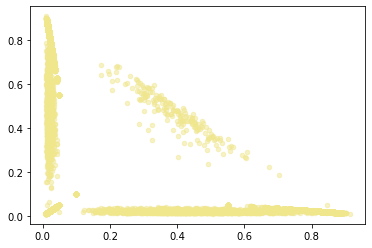

In [69]:
display_cluster(topic_values)

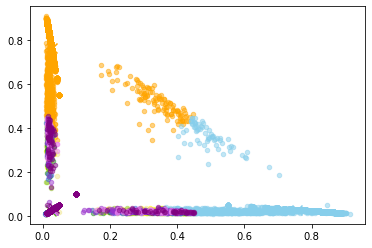

In [70]:
num_clusters = 10
# We set n_init=1 so that we can see one particular outcome
km = KMeans(n_clusters=num_clusters, random_state=10, n_init=1)
km.fit(topic_values)

display_cluster(topic_values,km,num_clusters)

### Plot the inertia to find the elbow

In [72]:
inertias = []
import numpy as np
for k_ in np.arange(1, 10):
    km = KMeans(n_clusters=k_)
    km.fit(topic_values)
    inertias.append(km.inertia_)


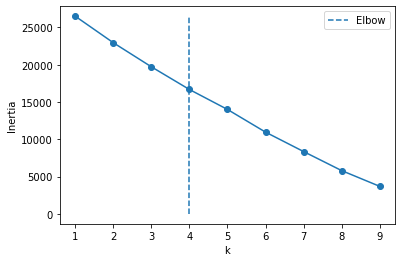

In [86]:
plt.plot(np.arange(1, 10), inertias, marker='o')
plt.vlines(x=4, ymin=0, ymax=max(inertias), ls='--', label='Elbow')
plt.ylabel("Inertia")
plt.xlabel('k')
plt.legend();
plt.savefig('Intertia.png')

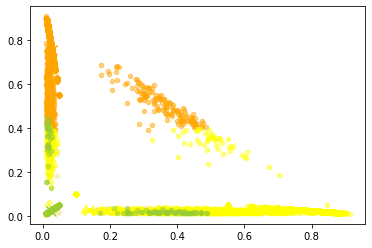

In [88]:
num_clusters = 4
# We set n_init=1 so that we can see one particular outcome
km = KMeans(n_clusters=num_clusters, random_state=10, n_init=1)
km.fit(topic_values)

display_cluster(topic_values,km,num_clusters)

## Heatmap by year

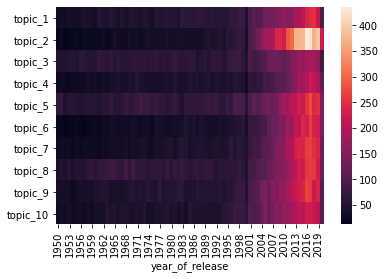

In [85]:
import seaborn as sns
year_df = plot_topic_df.groupby('year_of_release').sum()
sns.heatmap(year_df.T)
plt.savefig("heatmap.png")

## LDA with genism

In [77]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stemmed_stop_words,min_df=0.01,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              stemmer = PorterStemmer())

tf_result = nlp.fit_transform(corpus)

In [78]:
tf_result.T.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.10145001, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [79]:
from gensim import interfaces, utils, matutils
corpus = matutils.Sparse2Corpus(tf_result.T)
id2word = dict((v, k) for k, v in nlp.vectorizer.vocabulary_.items())

In [80]:
import gensim
import gensim.corpora as corpora
from gensim import interfaces, utils, matutils

corpus = matutils.Sparse2Corpus(tf_result.transpose())
id2word = dict((v, k) for k, v in nlp.vectorizer.vocabulary_.items())

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=10)

In [81]:
lda_model.print_topics()

[(0,
  '0.018*"town" + 0.017*"small" + 0.012*"live" + 0.010*"small town" + 0.010*"life" + 0.009*"famili" + 0.009*"peopl" + 0.008*"differ" + 0.008*"road" + 0.007*"commun"'),
 (1,
  '0.017*"war" + 0.013*"fight" + 0.012*"gang" + 0.011*"soldier" + 0.011*"prison" + 0.010*"battl" + 0.010*"group" + 0.009*"team" + 0.009*"govern" + 0.008*"forc"'),
 (2,
  '0.018*"music" + 0.014*"featur" + 0.011*"actor" + 0.011*"play" + 0.011*"life" + 0.010*"world" + 0.009*"perform" + 0.009*"artist" + 0.009*"band" + 0.009*"drama"'),
 (3,
  '0.017*"murder" + 0.014*"investig" + 0.012*"polic" + 0.012*"case" + 0.012*"mysteri" + 0.011*"killer" + 0.009*"kill" + 0.009*"detect" + 0.008*"crime" + 0.007*"mission"'),
 (4,
  '0.025*"filmmak" + 0.016*"young" + 0.016*"girl" + 0.015*"explor" + 0.013*"comedi" + 0.012*"life" + 0.012*"live" + 0.011*"love" + 0.011*"path" + 0.011*"struggl"'),
 (5,
  '0.016*"school" + 0.016*"love" + 0.011*"friend" + 0.010*"life" + 0.009*"student" + 0.009*"high" + 0.009*"high school" + 0.008*"famili" 

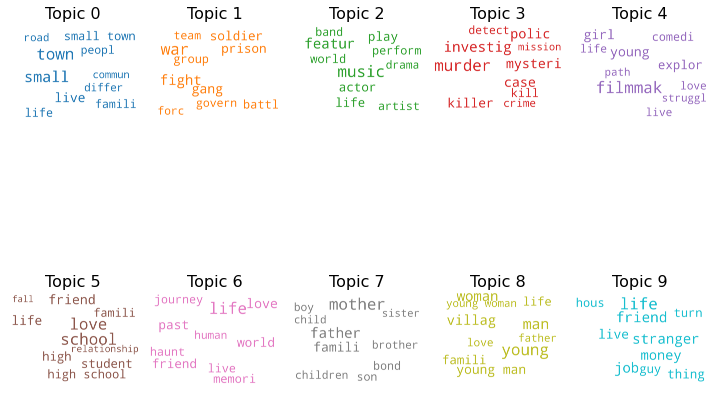

In [82]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Got some good clusters and topics so now I will explore a books dataset for my recommender